# BigClam: Cluster Affiliation Model
This algorithm works only for undirected unlabeled (unweighted) networks

In [3]:
import os
from graph_tool.all import *
import codecs
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
from igraph import *
from scipy.stats.stats import pearsonr
from scipy import stats
import pandas as pd
import math
import json
import seaborn as sns
plt.style.use('seaborn-white')
sns.set(font_scale=2) 
sns.set_style("white")
default_stdout = sys.stdout
sys.stdout = default_stdout

In [4]:
WORKING_FOLDER = '../../../DATA/FIN/BigClam'
os.chdir(WORKING_FOLDER)
f_in_graph = 'mention_graph_weights.dat'
f_in_BigClam_output_comm = '7sautocmtyvv.txt'

# Read in data

In [5]:
def read_in_node_names():
    f = open('mutual_unweighted_node_names', 'r')
    node_names = defaultdict(int)
    for line in f:
        if line[0] == '#':
            continue
        node_id, node_name = line.split()
        node_names[int(node_id)] = int(node_name)
    return node_names

In [9]:
# returns a dict with nodes ids per community in each value
# dict keys are just community ids in returned order 
def read_BigClam_output(change_node_names=True):  
    input_file = codecs.open(f_in_BigClam_output_comm, 'r', encoding='utf8')
    BigClam_output = defaultdict(list)
    num_COMM = 0
    for line in input_file:
        line = line.split()
        BigClam_output[num_COMM] = line
        num_COMM += 1
        
    # this part is needed since I did not know how to tell
    # to BigClam to operate on my real node names, so I
    # gave it a Node id edge list instead
    if change_node_names:
        BigClam_output2 = defaultdict(list)
        node_names = read_in_node_names()
        for comm in BigClam_output:
            BigClam_output2[comm] = [node_names[int(x)] for x in BigClam_output[comm]]
        return BigClam_output2        
                
    return BigClam_output

read_BigClam_output();

In [10]:
def read_in_top_communities(sizeN):
    ordered_communities = OrderedDict(sorted(read_BigClam_output().items(), key=lambda t:len(t[1]), reverse=True))
    top_communities = OrderedDict(x for x in ordered_communities.items() if len(x[1])>sizeN)
    return top_communities

In [11]:
# returns a set of communities in which each node belongs to
def find_nodes_COMM():
    nodes_COMM = defaultdict(list)
    output = read_BigClam_output()
    for comm in output.keys():
        for node in output[comm]:
            nodes_COMM[node].append(comm)
            
    for node in nodes_COMM:
            nodes_COMM[node] = list(set(nodes_COMM[node]))
    return nodes_COMM

In [12]:
# a helper function to show us info when print info is true
# otherwise returns only the list of community sizes
def num_and_sizes_BigClam_COMM(print_info=False):
    num_COMM = 0
    COMM_sizes = []
    ALL_users = defaultdict(int)
    BigClam_COMM = read_BigClam_output()
    num_COMM = len(BigClam_COMM.keys())
    for comm in BigClam_COMM:
        COMM_sizes.append(len(BigClam_COMM[comm]))
        for el in BigClam_COMM[comm]:
            ALL_users[el] = 1
    if print_info:
        print 'BigClam has output: %d COMM ' % (num_COMM)
        print 'Their sizes in increasing order:'
        print sorted(COMM_sizes)
        print 'Total number of users in COMM:'
        print len(ALL_users.keys())
        print 'Total size of COMM:'
        print sum(COMM_sizes)
    return COMM_sizes
    return COMM_sizes

In [13]:
num_and_sizes_BigClam_COMM(print_info=True);

BigClam has output: 512 COMM 
Their sizes in increasing order:
[6, 7, 7, 9, 9, 9, 9, 10, 10, 11, 11, 11, 12, 12, 13, 14, 14, 14, 15, 16, 18, 18, 19, 19, 20, 20, 21, 23, 23, 23, 23, 24, 24, 27, 28, 28, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 33, 33, 37, 37, 37, 37, 37, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64,

In [15]:
# returns the node membership for each node
# i.e., in how many communities it participates
def find_nodes_in_more_COMM(print_info=False):
    nodes_num_COMM = defaultdict(int)
    BigClam_COMM = read_BigClam_output()
    for comm in BigClam_COMM:
        for node in BigClam_COMM[comm]:
            nodes_num_COMM[int(node)] += 1
    all_nodes = read_in_node_names().values()
    cnt_singletons = 0
    
    for node in all_nodes:
        if node not in nodes_num_COMM:
            cnt_singletons += 1
    if print_info:
        print len(all_nodes), len(nodes_num_COMM.keys())
        print 'I found nodes out of communities ', cnt_singletons
    #nodes_num_COMM2 = {node: nodes_num_COMM[node] if nodes_num_COMM[node] < 10 else 10 for node in nodes_num_COMM}
    sorted_nodes_num_COMM = OrderedDict(sorted(nodes_num_COMM.items(), key=lambda t:t[1], reverse=True))
    global N_overlap_comm
    print sorted_nodes_num_COMM.items()[0][1]
    
    #print sorted_nodes_num_COMM
    return sorted_nodes_num_COMM


find_nodes_in_more_COMM(print_info=True);

26717 20833
I found nodes out of communities  5884
37


In [16]:
find_nodes_in_more_COMM();
#print N_overlap_comm

37


# Let us visualize the overalpping community structure

In [17]:
# plots complementary CDF for the membership per node
# in log-log scale
def plot_ccdf_node_comm_membership():
    nodes_num_COMM = find_nodes_in_more_COMM()
    data = np.array(nodes_num_COMM.values())
    sorted_data = np.sort(data)
    yvals=1-np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,color='r')
    plt.yscale('log')
    plt.ylabel('complementary CDF')
    plt.xscale('log')
    plt.xlabel('comm memberships')
    plt.savefig('ccdf_memberships.jpg')
    plt.show()

37


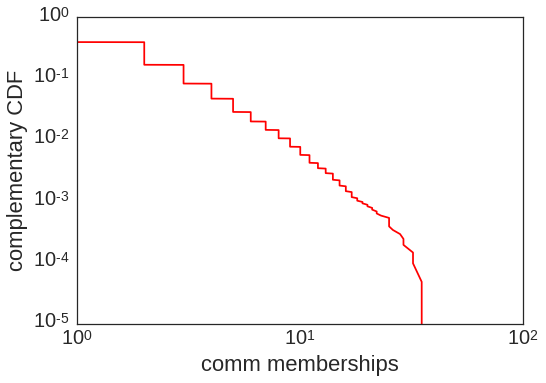

In [18]:
plot_ccdf_node_comm_membership()

In [19]:
# plots complementary CDF for the comm sizes
# in log-log scale
def plot_ccdf_comm_sizes():
    COMM_sizes = num_and_sizes_BigClam_COMM()
    data = np.array(COMM_sizes)
    sorted_data = np.sort(data)
    yvals=1-np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,color='r', label='BigClam')
    plt.yscale('log')
    plt.ylabel('complementary CDF')
    plt.xscale('log')
    plt.xlabel('community size')
    plt.legend()
    plt.savefig('BigClam_ccdf_comm_sizes.jpg')
    plt.show()

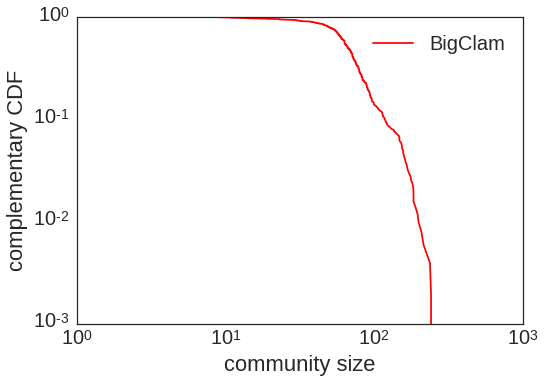

In [20]:
plot_ccdf_comm_sizes()

# Degree

In [24]:
def read_in_graph():
    G = Graph.Read_Ncol(f_in_graph, directed=True, weights=True)
    print f_in_graph
    print G.summary()
    return G

In [25]:
def find_avg_WEIGHTED_deg_per_node_COMM_membership():
    node_comm_membership = find_nodes_in_more_COMM()
    G = read_in_graph()
    G_undir = G.copy()
    # this copy is then transformed into undir weighted mutual
    G_undir.to_undirected(mode="mutual", combine_edges='min')
    res = defaultdict(list)
    for node in node_comm_membership:
        n = G_undir.vs.select(name = str(node))
        nCOMM = node_comm_membership[node] if node_comm_membership[node] < 10 else 10
        res[nCOMM].append(G_undir.strength(n[0].index, weights='weight'))
    res_mean = defaultdict(float)
    res_stdev = defaultdict(float)
    for COMM in res:
        res_mean[COMM] = np.mean(np.array(res[COMM]))
        res_stdev[COMM] = np.std(np.array(res[COMM]))
    return res_mean, res_stdev

In [26]:
def plot_WEIGHTED_deg_vs_COMM_membership():
    d, std = find_avg_WEIGHTED_deg_per_node_COMM_membership()
    x = d.keys()
    y = d.values()
    e = std.values()
    fig7s = plt.gcf()
    fig7s.set_size_inches((8,6))
    sns.set_style('white')
    print 'Corrcoef strong commun int and comm membership ',  pearsonr(np.array(x), np.array(y))
    plt.errorbar(x,y,e,linestyle="-",marker='*',color='maroon',label='mean strong communication intensity')
    #plt.yscale('log', nonposy='clip')
    plt.xlabel('node comm membership')
    plt.ylabel('mean strong communication intensity')
    plt.legend(loc='best',frameon=False)
    plt.xlim(0,11)
    #plt.title(r'Histogram for mention network pairwise SR: $\mu=' +  "{:.3f}".format(mu) + '$, $\sigma= ' + "{:.3f}".format(sigma) + '$')
    plt.grid(True)
    plt.savefig('node_comm_membership_vs_mean_strong_comm_intensity2.eps', dpi=550)
    plt.show()

37
mention_graph_weights.dat
IGRAPH DNW- 26717 99910 -- 
+ attr: name (v), weight (e)
Corrcoef strong commun int and comm membership  (0.56148824531852382, 0.091224637255369265)


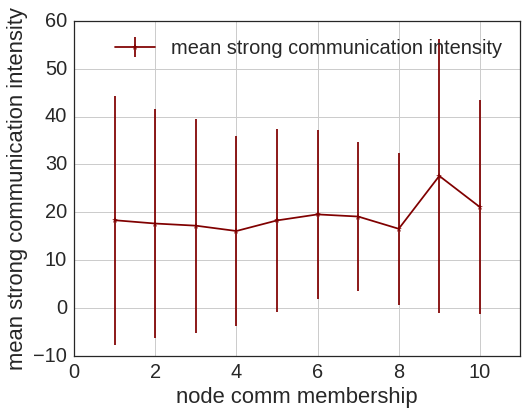

In [27]:
plot_WEIGHTED_deg_vs_COMM_membership()

# Now we add SR values and graph into the story
We want to see does community size correlate with average SR

In [15]:
# reads in the graph using igraph and Ncol format, i.e., edge list
# with weights being the SR on the edges
def read_in_SR_graph():
    #G = Graph.Read_Ncol('undirected_mention_graph_with_SR.csv', directed=False, weights=True)
    #G = read("test", format="ncol", directed=False, weights=True)
    G = Graph.Read_Ncol('directed_mention_graph_with_SR_NCOL_edgelist', directed=True, weights=True, names=True)
    #print G.summary()
    G.to_undirected(mode="collapse", combine_edges=min)
    #print G.summary()
    #G.simplify(combine_edges=None)
    #print G.summary()
    return G
read_in_SR_graph()

Next function uses igraph to first find a subgraph induced by the community
and to then calculate average SR on its edges. It is relatively fast given that
other implementation I took (iterating through nodes) were really slow.

In [16]:
# find average SR between the connected nodes
# in the subgraph of G induced by the nodes
def find_avg_SR(G, nodes):
    node_SR_list = []
    node_indices = []
    for el in nodes:
        n = G.vs.select(name = str(el))[0]
        n = n.index
        node_indices.append(n)
    edges = G.es.select(_within = node_indices)
    for e in edges:
        w = e['weight']
        node_SR_list.append(w)
    avg_SR = np.mean(np.array(node_SR_list))
    std_SR = np.std(np.array(node_SR_list))
    return (avg_SR, std_SR)      

We now combine the BigClam output and previous function
to find avergage SR per community

In [17]:
def avg_SR_per_COMM_size():
    BigClam_output = read_BigClam_output()
    G = read_in_SR_graph()
    size_vs_SR = defaultdict(int)
    for comm_nodes in BigClam_output.values():
        size_vs_SR[len(comm_nodes)] = find_avg_SR(G, comm_nodes)
    sorted_size_vs_SR = OrderedDict(sorted(size_vs_SR.items(), key=lambda t:t[0], reverse=True))
    return size_vs_SR

We now plot the distribution. There is *no* correlation.

In [18]:
def plot_avg_SR_per_COMM_size():
    size_vs_SR = avg_SR_per_COMM_size()
    x = np.array(size_vs_SR.keys())
    y = np.array([s[0] for s in size_vs_SR.values()])
    e = np.array([s[1] for s in size_vs_SR.values()])
    print 'Corrcoef',  pearsonr(x, y)
    plt.errorbar(x,y,e,linestyle="-",marker='*',color='maroon',label='mean SR per comm')
    #plt.yscale('log', nonposy='clip')
    plt.xlabel('comm size')
    plt.ylabel('mean SR')
    plt.legend(loc='best',frameon=False)
    plt.show()

In [19]:
#plot_avg_SR_per_COMM_size()

In [20]:
def scatterplot_avg_SR_per_COMM_size():
    size_vs_SR = avg_SR_per_COMM_size()
    x = np.array(size_vs_SR.keys())
    y = np.array([s[0] for s in size_vs_SR.values()])
    e = np.array([s[1] for s in size_vs_SR.values()])
    print 'Corrcoef',  pearsonr(x, y)
    plt.scatter(x,y, label='mean SR per comm')
    plt.xlabel('comm size')
    plt.ylabel('mean SR')
    plt.legend(loc='best',frameon=False)
    plt.show()

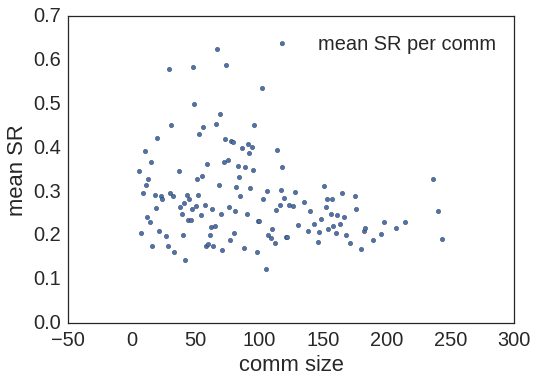

In [107]:
scatterplot_avg_SR_per_COMM_size()

In [21]:
def read_sem_capital(f_name='user_entities.tab', tname='entities'):
    f = open(f_name, "r")
    cap = defaultdict(int)
    cnt = 0
    for line in f:
        if tname == 'sentiment':
            (vid, vn, val) = line.split('\t')
            val = float(val)
        else:
            (vid, val) = line.split('\t')
            val = float(val)
        cap[vid] = val
        cnt += 1
    return cap

In [22]:
def find_avg_SEM_CAP(sem_cap, comm_nodes):
    s = []
    for node in comm_nodes:
        s.append(sem_cap[str(node)])
    s_mean = np.mean(np.array(s))
    s_std = np.std(np.array(s))
    return (s_mean, s_std)

In [23]:
def avg_SEM_CAP_per_COMM_size():
    output = read_BigClam_output()
    sem_cap = read_sem_capital()
    size_vs_SEM_CAP = defaultdict(int)
    for comm_nodes in output.values():
        size_vs_SEM_CAP[len(comm_nodes)] = find_avg_SEM_CAP(sem_cap, comm_nodes)
    sorted_size_vs_SEM_CAP = OrderedDict(sorted(size_vs_SEM_CAP.items(), key=lambda t:t[0], reverse=True))
    return size_vs_SEM_CAP

In [24]:
def scatterplot_avg_SEM_CAP_per_COMM_size():
    size_vs_SEM_CAP = avg_SEM_CAP_per_COMM_size()
    x = np.array(size_vs_SEM_CAP.keys())
    y = np.array([s[0] for s in size_vs_SEM_CAP.values()])
    e = np.array([s[1] for s in size_vs_SEM_CAP.values()])
    print 'Corrcoef',  pearsonr(x, y)
    plt.scatter(x,y)
    plt.xlabel('comm size')
    plt.ylabel('mean sem cap')
    #plt.xscale('log')
    #plt.legend(loc='best',frameon=False)
    plt.show()

Corrcoef (0.066480521341523588, 0.43681860299867026)


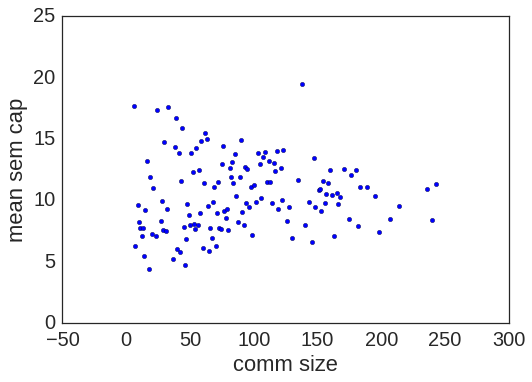

In [29]:
scatterplot_avg_SEM_CAP_per_COMM_size()

# Community memeberhsip, i.e., pluralistic homophily

In [16]:
N_overlap_comm = 10

In [21]:
def how_many_nodes_with_pluralistic_level():
    node_comm_membership = find_nodes_in_more_COMM()
    pluralisic_classes_sizes = defaultdict(int)
    for node in node_comm_membership:
        pluralisic_classes_sizes[node_comm_membership[node]] += 1
    return pluralisic_classes_sizes
#how_many_nodes_with_pluralistic_level() 

In [79]:
def find_avg_neighborhood_SR_per_node_COMM_membership():
    node_comm_membership = find_nodes_in_more_COMM()
    G = read_in_SR_graph()
    res = defaultdict(list)
    for node in node_comm_membership:
        n = G.vs.select(name = str(node))
        nCOMM = node_comm_membership[node] if node_comm_membership[node] <= N_overlap_comm else N_overlap_comm
        try:
            total_SR = G.strength(n[0].index, weights='weight')
        except IndexError:
            continue
        total_neighbors = G.degree(n[0].index)
        meanSR =  total_SR / float(total_neighbors)
        res[nCOMM].append(meanSR)
    res_mean = defaultdict(float)
    res_stdev = defaultdict(float)
    for COMM in res:
        res_mean[COMM] = np.mean(np.array(res[COMM]))
        res_stdev[COMM] = np.std(np.array(res[COMM]))
    return res_mean, res_stdev

In [22]:
def plot_avg_neighborhood_SR_vs_COMM_membership():
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('user comm membership')
    
    d, std = find_avg_neighborhood_SR_per_node_COMM_membership()
    x = d.keys()
    y = d.values()
    e = std.values()
    ax1.set_ylabel('mean node SR with neighbors', color='red')
    ax1.tick_params('y', colors='red')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='red',fmt='o',elinewidth=2.0, label='BigClam')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.set_ylim([-0.5,1.5])
    
    ax2 = ax1.twinx()
    pluralistic_classes = how_many_nodes_with_pluralistic_level()
    z = np.array([pluralistic_classes[s] for s in x])
    ax2.scatter(x,z,marker='o',color='blue')
    ax2.plot(x,z,'-', color='blue')
    ax2.set_ylabel('total users', color='blue')
    ax2.tick_params('y', colors='blue')
    ax2.set_yscale('log')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.legend()
    
    print 'Corrcoef SR and comm membership ',  pearsonr(np.array(x), np.array(y))

    #plt.title(r'Histogram for mention network pairwise SR: $\mu=' +  "{:.3f}".format(mu) + '$, $\sigma= ' + "{:.3f}".format(sigma) + '$')
    #plt.grid(True)
    plt.savefig('BigClam_node_comm_membership_vs_mean_SR.jpg', bbox_inches='tight')
    plt.show()

NameError: global name 'find_avg_neighborhood_SR_per_node_COMM_membership' is not defined

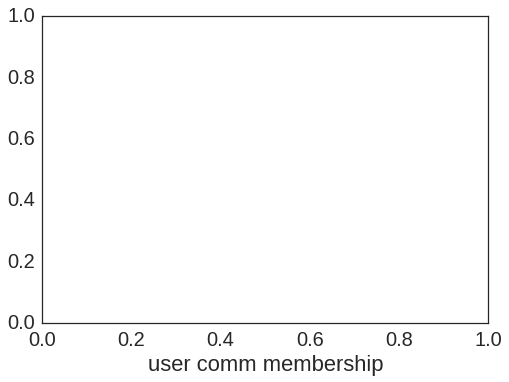

In [23]:
plot_avg_neighborhood_SR_vs_COMM_membership()

# Semantic capitals and pluralistic

In [24]:
def read_sem_capital(f_name='user_entities.tab', tname='entities'):
    f = open(f_name, "r")
    cap = defaultdict(int)
    cnt = 0
    for line in f:
        if tname == 'sentiment':
            (vid, vn, val) = line.split('\t')
            val = float(val)
        else:
            (vid, val) = line.split('\t')
            val = float(val)
        cap[vid] = val
        cnt += 1
    return cap

In [25]:
def find_avg_SEM_cap_per_node_COMM_membership():
    node_comm_membership = find_nodes_in_more_COMM()
    sem_cap = read_sem_capital()
    res = defaultdict(list)
    for node in node_comm_membership:
        n_sem = sem_cap[str(node)]
        nCOMM = node_comm_membership[node] if node_comm_membership[node] < N_overlap_comm else N_overlap_comm
        res[nCOMM].append(n_sem)
    res_mean = defaultdict(float)
    res_stdev = defaultdict(float)
    for COMM in res:
        res_mean[COMM] = np.mean(np.array(res[COMM]))
        res_stdev[COMM] = np.std(np.array(res[COMM]))
    return res_mean, res_stdev

In [26]:
def plot_SEM_CAP_vs_COMM_membership():
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('user comm membership')
    
    d, std = find_avg_SEM_cap_per_node_COMM_membership()
    x = d.keys()
    y = d.values()
    e = std.values()
    ax1.set_ylabel('mean user semantic capital', color='darkred')
    ax1.tick_params('y', colors='darkred')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='darkred',fmt='o',elinewidth=2.0, label='BigClam')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.set_ylim([-10,30])
    
    ax2 = ax1.twinx()
    pluralistic_classes = how_many_nodes_with_pluralistic_level()
    z = np.array([pluralistic_classes[s] for s in x])
    ax2.scatter(x,z,marker='o',color='blue')
    ax2.plot(x,z,'-', color='blue')
    ax2.set_ylabel('total users', color='blue')
    ax2.tick_params('y', colors='blue')
    ax2.set_yscale('log')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.legend()
    
    print 'Corrcoef SEM CAP and comm membership ',  pearsonr(np.array(x), np.array(y))
      
    #plt.tight_layout()
    plt.savefig('node_comm_membership_vs_SEM_CAP.jpg', bbox_inches='tight')
    plt.show()

37
37
Corrcoef SEM CAP and comm membership  (0.341821126932218, 0.33367831280437876)


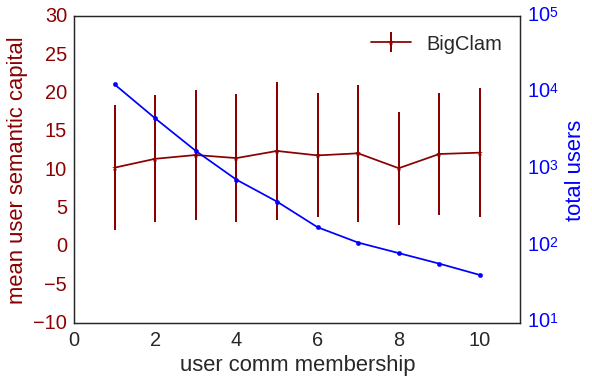

In [27]:
plot_SEM_CAP_vs_COMM_membership()

# Let us try something new with shared communities

In [28]:
N_shared = 10

In [29]:
def read_in_mention_graph():
    d = defaultdict(int)
    fn = 'mention_graph_weights.dat'
    f = open(fn, 'r')
    for line in f:
        (u1, u2, w) = line.split()
        d[int(u1), int(u2)] = int(w)
    return d

In [30]:
def find_node_interaction_comm_propensity():
    d = read_in_mention_graph()
    cnt_edges = 0
    node_comm_membership = find_nodes_COMM()
    comm_mem = defaultdict(list)
    comm_mem_total_pairs = defaultdict(list)
    
    max_shared = 0
    for (u1, u2) in d:
        comms_u1 = node_comm_membership[int(u1)]
        comms_u2 = node_comm_membership[int(u2)]
        shared = len(set(comms_u1).intersection(set(comms_u2)))
        if shared > max_shared:
            max_shared = shared
        if shared > N_shared:
            shared = N_shared 
        comm_mem[shared].append(d[(u1, u2)])
        if shared not in comm_mem_total_pairs:
            comm_mem_total_pairs[shared] = defaultdict(int)
        if u2 > u1:
            pom = u2
            u2 = u1
            u1 = pom
        comm_mem_total_pairs[shared][((u1, u2))] = 1
        cnt_edges += 1
    N = cnt_edges
    print N
    
    comm_mem_mean = OrderedDict()
    comm_mem_std = OrderedDict()
    

    for comm in comm_mem:
        comm_mem_mean[comm] = np.mean(np.array(comm_mem[comm]))
        comm_mem_std[comm] = np.std(np.array(comm_mem[comm]))
        comm_mem_total_pairs[comm] = sum(comm_mem_total_pairs[comm].values())
    print 'Max shared COMM ', max_shared
    return comm_mem_mean, comm_mem_std, comm_mem_total_pairs

In [31]:
def plot_interaction_comm_propensity():
    comm_mem_mean, comm_mem_std, comm_mem_total_pairs = find_node_interaction_comm_propensity()

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('shared comm between nodes')
    
    x = comm_mem_mean.keys()
    y = comm_mem_mean.values()
    e = comm_mem_std.values()
    z = comm_mem_total_pairs.values()

    ax1.set_ylabel('communication intensity', color='r')
    ax1.tick_params('y', colors='r')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='r',fmt='o',elinewidth=2.0)
    ax1.set_xlim([-1,N_shared+1])
    
    ax2 = ax1.twinx()
    ax2.scatter(x,z,marker='o',color='darkblue')
    ax2.plot(x,z,'-', color='darkblue')
    ax2.set_ylabel('total user pairs', color='darkblue')
    ax2.tick_params('y', colors='darkblue')
    ax2.set_yscale('log')
    ax2.set_xlim([-1,N_shared+1])
    
    plt.savefig('node_shared_comm_vs_CI.jpg', bbox_inches='tight')
    
    print pearsonr(np.array(x), np.array(y))

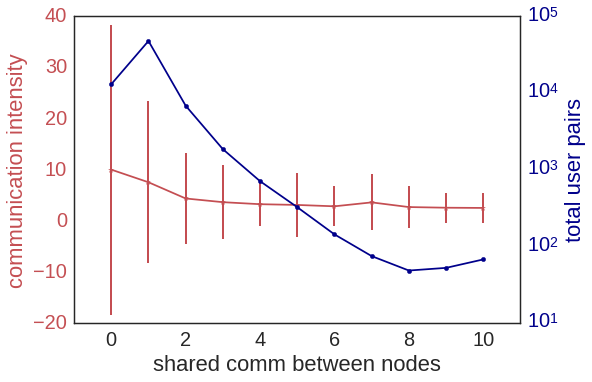

In [142]:
plot_interaction_comm_propensity()

# SR vs shared comm 

In [71]:
def read_in_SR_graph_simple():
    d = defaultdict(int)
    fn = 'mention_graph_IDs_with_SR.dat'
    f = open(fn, 'r')
    for line in f:
        (u1, u2, w) = line.split()
        d[int(u1), int(u2)] = float(w)
    return d

In [72]:
def find_node_SR_vs_shared_comm():
    d = read_in_SR_graph_simple()
    cnt_edges = 0
    node_comm_membership = find_nodes_COMM()
    comm_mem = defaultdict(list)
    comm_mem_total_pairs = defaultdict(list)
    
    max_shared = 0
    for (u1, u2) in d:
        comms_u1 = node_comm_membership[int(u1)]
        comms_u2 = node_comm_membership[int(u2)]
        shared = len(set(comms_u1).intersection(set(comms_u2)))
        if shared > max_shared:
            max_shared = shared
        if shared > N_shared:
            shared = N_shared 
        comm_mem[shared].append(d[(u1, u2)])
        if shared not in comm_mem_total_pairs:
            comm_mem_total_pairs[shared] = defaultdict(int)
        if u2 > u1:
            pom = u2
            u2 = u1
            u1 = pom
        comm_mem_total_pairs[shared][((u1, u2))] = 1
        cnt_edges += 1
    N = cnt_edges
    print N
    
    comm_mem_mean = OrderedDict()
    comm_mem_std = OrderedDict()
    

    for comm in comm_mem:
        comm_mem_mean[comm] = np.mean(np.array(comm_mem[comm]))
        comm_mem_std[comm] = np.std(np.array(comm_mem[comm]))
        comm_mem_total_pairs[comm] = sum(comm_mem_total_pairs[comm].values())
    print 'Max shared COMM ', max_shared
    return comm_mem_mean, comm_mem_std, comm_mem_total_pairs

In [90]:
def plot_SR_vs_shared_comm():
    comm_mem_mean, comm_mem_std, comm_mem_total_pairs = find_node_SR_vs_shared_comm()

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('shared comm between nodes')
    
    x = comm_mem_mean.keys()
    y = comm_mem_mean.values()
    e = comm_mem_std.values()
    z = comm_mem_total_pairs.values()

    ax1.set_ylabel('SR', color='green')
    ax1.tick_params('y', colors='green')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='green',fmt='o',elinewidth=2.0, label='BigClam')
    ax1.set_xlim([-1,N_shared+1])
    
    ax1.set_ylim([-0.5,1.5])
    
    ax2 = ax1.twinx()
    ax2.scatter(x,z,marker='o',color='darkblue')
    ax2.plot(x,z,'-', color='darkblue')
    ax2.set_ylabel('total user pairs', color='darkblue')
    ax2.tick_params('y', colors='darkblue')
    ax2.set_yscale('log')
    ax2.set_xlim([-1,N_shared+1])
    
    ax1.legend()

    plt.savefig('Bigclam_node_shared_comm_vs_SR.jpg', bbox_inches='tight')
    
    print pearsonr(np.array(x), np.array(y))

99910
Max shared COMM  28
(0.93082765965133552, 3.1881010292823013e-05)


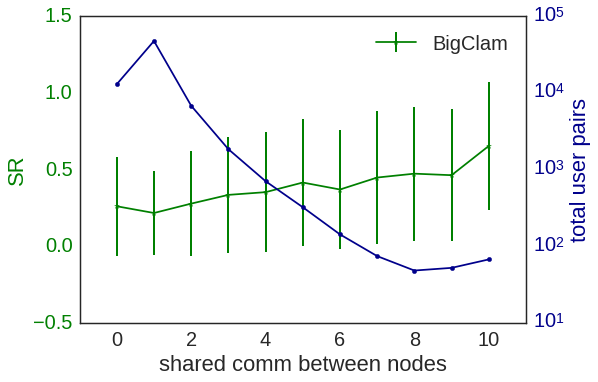

In [91]:
plot_SR_vs_shared_comm()

# Sentiment diff vs shared comm 

In [68]:
def find_node_sentiment_vs_shared_comm():
    d = read_in_SR_graph_simple()
    sent = read_sem_capital(f_name='user_sentiment.tab', tname='sentiment')
    cnt_edges = 0
    node_comm_membership = find_nodes_COMM()
    comm_mem = defaultdict(list)
    comm_mem_total_pairs = defaultdict(list)
    
    max_shared = 0
    for (u1, u2) in d:
        comms_u1 = node_comm_membership[int(u1)]
        comms_u2 = node_comm_membership[int(u2)]
        shared = len(set(comms_u1).intersection(set(comms_u2)))
        if shared > max_shared:
            max_shared = shared
        if shared > N_shared:
            shared = N_shared 
        comm_mem[shared].append(abs(sent[str(u1)] - sent[str(u2)]))
        if shared not in comm_mem_total_pairs:
            comm_mem_total_pairs[shared] = defaultdict(int)
        if u2 > u1:
            pom = u2
            u2 = u1
            u1 = pom
        comm_mem_total_pairs[shared][((u1, u2))] = 1
        cnt_edges += 1
    N = cnt_edges
    print N
    
    comm_mem_mean = OrderedDict()
    comm_mem_std = OrderedDict()
    

    for comm in comm_mem:
        comm_mem_mean[comm] = np.mean(np.array(comm_mem[comm]))
        comm_mem_std[comm] = np.std(np.array(comm_mem[comm]))
        comm_mem_total_pairs[comm] = sum(comm_mem_total_pairs[comm].values())
    print 'Max shared COMM ', max_shared
    return comm_mem_mean, comm_mem_std, comm_mem_total_pairs

In [88]:
def plot_sent_diff_vs_shared_comm():
    comm_mem_mean, comm_mem_std, comm_mem_total_pairs = find_node_sentiment_vs_shared_comm()

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('shared comm between nodes')
    
    x = comm_mem_mean.keys()
    y = comm_mem_mean.values()
    e = comm_mem_std.values()
    z = comm_mem_total_pairs.values()

    ax1.set_ylabel('sentiment difference', color='gray')
    ax1.tick_params('y', colors='gray')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='gray',fmt='o',elinewidth=2.0, label='BigClam')
    ax1.set_xlim([-1,N_shared+1])
    
    ax1.set_ylim([-0.5,1])
    
    ax2 = ax1.twinx()
    ax2.scatter(x,z,marker='o',color='darkblue')
    ax2.plot(x,z,'-', color='darkblue')
    ax2.set_ylabel('total user pairs', color='darkblue')
    ax2.tick_params('y', colors='darkblue')
    ax2.set_yscale('log')
    ax2.set_xlim([-1,N_shared+1])
    
    ax1.legend(loc='best')
    
    
    
    plt.savefig('Bigclam_node_shared_comm_vs_sentiment.jpg', bbox_inches='tight')
    
    
    print pearsonr(np.array(x), np.array(y))

99910
Max shared COMM  28
(-0.63579104704453959, 0.035504106654235722)


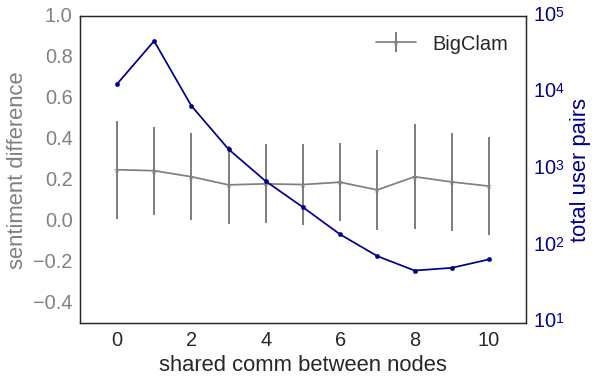

In [89]:
plot_sent_diff_vs_shared_comm()

# Community density

In [150]:
def find_overlapping_COMM():
    nodes_num_COMM = find_nodes_in_more_COMM()
    COMM_density = defaultdict(list)
    output = read_BigClam_output()

    for comm in output:
        for node in output[comm]:
            COMM_density[comm].append(nodes_num_COMM[int(node)])
            
    COMM_density2 =  defaultdict(tuple)
    for COMM in COMM_density:
        COMM_density2[COMM] = (np.mean(np.array(COMM_density[COMM])), len(COMM_density[COMM]))
    COMM_density3 = OrderedDict(sorted(COMM_density2.items(), key=lambda t:t[1][0]))
    
    return COMM_density3

In [151]:
def plot_COMM_size_vs_density():
    import seaborn as sns
    sns.set(color_codes=True, font_scale=2) 

    x = []
    y = []

    data = find_overlapping_COMM()
    
    for COMM in data:
        x.append(data[COMM][0])
        y.append(data[COMM][1])

    x = np.array(x)
    y = np.array(y)

    print 'Corrcoef COMM size and density ',  pearsonr(np.array(x), np.array(y))
    (r, p) = pearsonr(np.array(x), np.array(y))

    lab = r'$r=' +  "{:.2f}".format(r) + '$, $p= ' + "{:.2f}".format(p) + '$'
    xlabel = 'comm density'
    ylabel = 'comm size'

    #plt.scatter(x, y, edgecolors='none', c='c', label=lab)
    sns.set_style("white")
    g = sns.jointplot(x=x, y=y, kind='reg',annot_kws=dict(stat="r"), \
        joint_kws={'line_kws':{'color':'gray', 'alpha':0.3, 'markeredgewidth':0}}).set_axis_labels(xlabel, ylabel)

    regline = g.ax_joint.get_lines()[0]
    regline.set_color('c')
    regline.set_zorder('5')

    labelsx = ['0','','1','', '2','', '3','','4']
    g.ax_joint.set_xticklabels(labelsx)
    
    #plt.yscale('log')

    #plt.legend(frameon=0, loc=2)
    #plt.show()
    #plt.tight_layout()
    plt.savefig('node_comm_size_density777.pdf',bbox_inches='tight' , dpi=550)
    plt.show()

37
Corrcoef COMM size and density  (0.71892381002793437, 1.3522115026153236e-82)


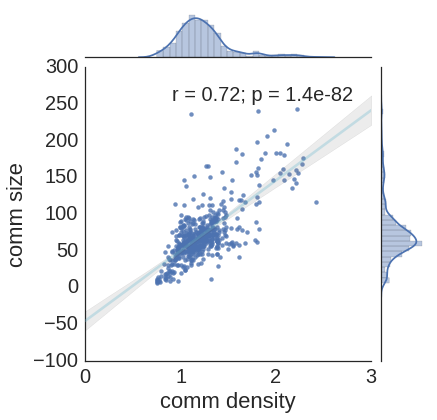

In [76]:
plot_COMM_size_vs_density()

In [51]:
def find_avg_ST_INC_per_node_COMM_membership():
    node_comm_membership = find_nodes_in_more_COMM()
    sem_cap = read_sem_capital(f_name='status_inconsistency', tname='status_inconsistency')
    res = defaultdict(list)
    for node in node_comm_membership:
        n_sem = sem_cap[str(node)] 
        nCOMM = node_comm_membership[node] if node_comm_membership[node] < N_overlap_comm else N_overlap_comm
        res[nCOMM].append(n_sem)
    res_mean = defaultdict(float)
    res_stdev = defaultdict(float)
    for COMM in res:
        res_mean[COMM] = np.mean(np.array(res[COMM]))
        res_stdev[COMM] = np.std(np.array(res[COMM]))
    return res_mean, res_stdev

In [86]:
def plot_ST_INC_vs_COMM_membership():
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('user comm membership')
    
    d, std = find_avg_ST_INC_per_node_COMM_membership()
    x = d.keys()
    y = d.values()
    e = std.values()
    ax1.set_ylabel('mean user $st_{inc}$', color='darkcyan')
    ax1.tick_params('y', colors='darkcyan')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='darkcyan',fmt='o',elinewidth=2.0,label='BigClam')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.set_ylim([-1.5,1.5])
    
    ax2 = ax1.twinx()
    pluralistic_classes = how_many_nodes_with_pluralistic_level()
    z = np.array([pluralistic_classes[s] for s in x])
    ax2.scatter(x,z,marker='o',color='darkblue')
    ax2.plot(x,z,'-', color='darkblue')
    ax2.set_ylabel('total users', color='darkblue')
    ax2.tick_params('y', colors='darkblue')
    ax2.set_yscale('log')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.legend()
    
    print 'Corrcoef ST INC and comm membership ',  pearsonr(np.array(x), np.array(y))
      
    #plt.tight_layout() 
    plt.savefig('node_comm_membership_vs_mean_ST_INC.eps', bbox_inches='tight')
    plt.show()

In [66]:
def plot_CONFINT_ST_INC_vs_COMM_membership():
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('user comm membership')
    
    d, std = find_avg_ST_INC_per_node_COMM_membership()
    x = d.keys()
    pluralistic_classes = how_many_nodes_with_pluralistic_level()
    z = np.array([pluralistic_classes[s] for s in x])
    y = d.values()
    stdv = std.values()
    e =stats.t.ppf(0.9, z-1)*stdv
    ax1.set_ylabel('mean user $st_{inc}$', color='darkcyan')
    ax1.tick_params('y', colors='darkcyan')
    ax1.errorbar(x,y,e,linestyle="-",marker='*',color='darkcyan',fmt='o',elinewidth=2.0,label='BigClam')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.set_ylim([-1,1])
    
    ax2 = ax1.twinx()
 
    
    ax2.scatter(x,z,marker='o',color='darkblue')
    ax2.plot(x,z,'-', color='darkblue')
    ax2.set_ylabel('total users', color='darkblue')
    ax2.tick_params('y', colors='darkblue')
    ax2.set_yscale('log')
    ax1.set_xlim([0,N_overlap_comm+1])
    
    ax1.legend(loc='best')
    
    print 'Corrcoef ST INC and comm membership ',  pearsonr(np.array(x), np.array(y))
      
    #plt.tight_layout() 
    plt.savefig('Infomap_node_comm_membership_vs_mean_ST_INC.eps', bbox_inches='tight')
    plt.show()

37
37
Corrcoef ST INC and comm membership  (0.89576893063860552, 0.00045455312907508879)


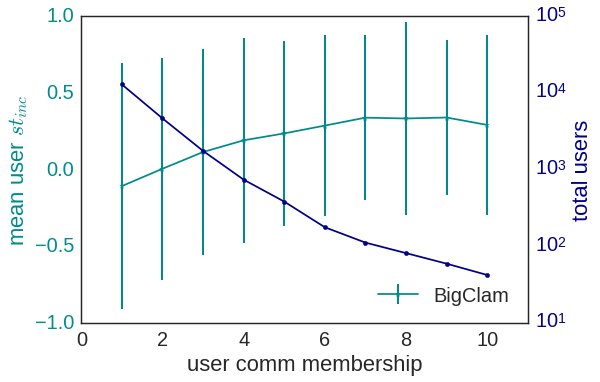

In [64]:
plot_CONFINT_ST_INC_vs_COMM_membership()

37
37
Corrcoef ST INC and comm membership  (0.89576893063860552, 0.00045455312907508879)


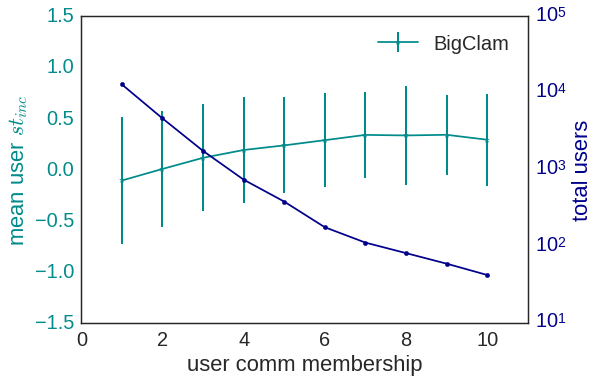

In [87]:
plot_ST_INC_vs_COMM_membership()

# Sentiment

In [165]:
def find_avg_sentiment_per_node_COMM_membership():
    node_comm_membership = find_nodes_in_more_COMM()
    sem_cap = read_sem_capital(f_name='user_sentiment.tab', tname='sentiment')
    res = defaultdict(list)
    for node in node_comm_membership:
        n_sem = sem_cap[str(node)]
        nCOMM = node_comm_membership[node] if node_comm_membership[node] < N_overlap_comm else N_overlap_comm
        res[nCOMM].append(n_sem)
    res_mean = defaultdict(float)
    res_stdev = defaultdict(float)
    for COMM in res:
        res_mean[COMM] = np.mean(np.array(res[COMM]))
        res_stdev[COMM] = np.std(np.array(res[COMM]))
    return res_mean, res_stdev

In [86]:
def plot_sentiment_vs_COMM_membership():
    d, std = find_avg_sentiment_per_node_COMM_membership()
    x = d.keys()
    y = d.values()
    e = std.values()
    print 'Corrcoef sentiment and comm membership ',  pearsonr(np.array(x), np.array(y))
    plt.errorbar(x,y,e,linestyle="-",marker='*',color='darkcyan',label='mean sentiment per comm membership ')
    #plt.yscale('log', nonposy='clip')
    plt.xlabel('node comm membership')
    plt.ylabel('mean node sentiment')
    #plt.legend(loc=2,frameon=False)
    plt.xlim(0,N_overlap_comm+1)
    #plt.ylim(-0.1,0.1)
    #plt.title(r'Histogram for mention network pairwise SR: $\mu=' +  "{:.3f}".format(mu) + '$, $\sigma= ' + "{:.3f}".format(sigma) + '$')
    #plt.grid(True)
    plt.savefig('node_comm_membership_vs_avg_sentiment.jpg')
    plt.show()

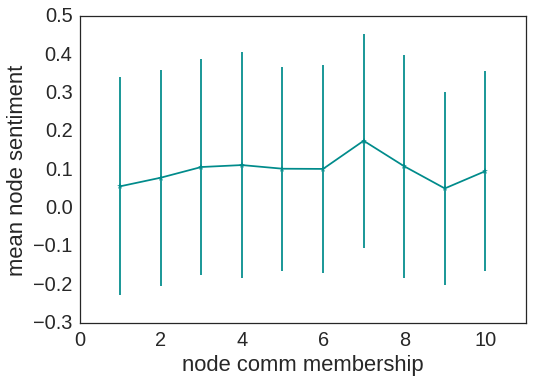

In [156]:
plot_sentiment_vs_COMM_membership()

# Entities, concepts, taxonomies etc.

In [96]:
##################################################
# read in a map for the twitter username --> id
##################################################
def read_user_IDs():

    user_ids = defaultdict(str)

    with codecs.open('../user_IDs.dat','r', encoding='utf8') as f:
        for line in f:
            line = line.split()
            user_id = line[0]
            user =  line[1]
            user_ids[user] = int(user_id)

    return user_ids

In [97]:
def plot_taxonomy(tokens, weights, max_tokens, tokens_name, COM='ALL'):
    df = pd.DataFrame({'token': tokens, 'weight': weights})
    df.sort('weight', inplace=True, ascending=False)
    if df.shape[0] > max_tokens:
        tail = df.ix[max_tokens:, 'weight'].sum()
        df2 = df.iloc[0:max_tokens].copy()
        nrow = pd.Series({'token': '--[other ' + tokens_name + ']--', 'weight': tail})
        df2.ix[df2.shape[0]] = nrow
        df2.index = np.arange(df2.shape[0])
    else:
        df2 = df
        
    # Let's plot something better than a word cloud!

    plt.figure(figsize=(10,5))
    plt.title('community ' + COM)
    colors = []
    for c in range(df2.shape[0]-1):
        colors.append('#383838')
    colors.append('#ebe728')
    plt.barh(df2.index * -1, np.log(df2['weight']), color=colors)
    plt.gca().yaxis.grid(False)
    plt.yticks(df2.index * -1 + 1.0, df2['token'])
    plt.ylim(-1 * df2.shape[0] + 1.4, 1)
    plt.xlabel(tokens_name + ' weight')
    plt.savefig(COM+tokens_name+'.jpg', bbox_inches='tight')
    if tokens_name == 'entity':
        plt.show()

In [98]:
##################################################
# the core function for the user lists, comm etc.
##################################################
"""
    here, the options are to visualize the taxonomy for the whole dataset (COM="ALL")
    and to visualize for different communities (COM="COM") that are read in through read_in_communities()
    in the case of communities, this functions is invoked once per each community
    -- user_list holds the ids of the users in one community
    -- TOP_N holds the number of top concepts, keywords and entities that we want to visualize and record
    -- user_com holds a map for user_id --> com_id
    -- N_COM holds the total number of communities found (changes depending on the community detection algorithm)
"""
def find_taxonomy_of_user_list(user_ids=read_user_IDs(), COM='ALL', user_list=None, TOP_N=20):

    # resulting dictionaries in which the counts and tfidf relevance are collected
    keywords_sum = defaultdict(int)
    entities_sum = defaultdict(int)
    concepts_sum = defaultdict(int)
    taxonomies_sum = defaultdict(int) 
    
    docSentiment_sum = defaultdict(int)
    
    print user_list

    cnt = 0
    with codecs.open('../tweets_taxonomy_clean.JSON','r', encoding='utf8') as input_file:
        for line7s in input_file:
            try:
                line = json.loads(line7s)
                user_name = line["_id"]
                user_name = str(user_name)
                user_id = user_ids[user_name]
                if user_list is not None:
                    if not user_id in user_list:
                        print user_id
                        continue
                # if dealing with ALL, take all the users
                taxonomy_all = line["taxonomy"]
                keywords = taxonomy_all["keywords"]
                entities = taxonomy_all["entities"]
                concepts = taxonomy_all["concepts"] 
                taxonomy = taxonomy_all["taxonomy"] 
                #
                docSentiment = taxonomy_all["docSentiment"] 
                # this counts how many user we have analyzed
                cnt += 1
            except KeyError:
                #print line7s
                # we don't print since it is tested, there some 10% users for whom
                # the taxonomy was not successfuly downloaded and they would be listed here
                continue
            
            for el in keywords:
                category = el["text"]
                # if we first time encounter this keyword, add a dict for it in the result
                if not category in keywords_sum:
                    keywords_sum[category] = defaultdict(int)
                # we use this not so well coded part because tuples do not allow assignment
                old_relev = keywords_sum[category][0]
                old_cnt = keywords_sum[category][1]
                new_relev = old_relev + float(el["relevance"])
                new_cnt = old_cnt + 1
                keywords_sum[category] = (new_relev, new_cnt)

            for el in entities:
                entity = el["text"]
                if entity in ['#', '#MentionTo', 'twitter', 'Twitter']:
                    continue
                # if we first time encounter this entity, add a dict for it in the result
                if not entity in entities_sum:
                    entities_sum[entity] = defaultdict(int)
                # we use this not so well coded part because tuples do not allow assignment
                old_relev = entities_sum[entity][0]
                old_cnt = entities_sum[entity][1]
                new_relev = old_relev + float(el["relevance"])
                new_cnt = old_cnt + 1
                entities_sum[entity] = (new_relev, new_cnt, el["type"])

            for el in concepts:
                concept = el["text"]
                if concept in ['Trigraph', 'Gh', 'trigraph']:
                    continue
                # if we first time encounter this concept, add a dict for it in the result
                if not concept in concepts_sum:
                    concepts_sum[concept] = defaultdict(int)
                # we use this not so well coded part because tuples do not allow assignment
                old_relev = concepts_sum[concept][0]
                old_cnt = concepts_sum[concept][1]
                new_relev = old_relev + float(el["relevance"])
                new_cnt = old_cnt + 1
                concepts_sum[concept] = (new_relev, new_cnt)

            # a bit different procedure for extracting the sentiment
            sentiment = docSentiment["type"]
            if sentiment == "neutral":
                docSentiment_sum[sentiment] += 1
            else:
                if not sentiment in docSentiment_sum:
                    docSentiment_sum[sentiment] = defaultdict(int)
                old_score = docSentiment_sum[sentiment][0]
                old_cnt = docSentiment_sum[sentiment][1]
                old_mixed_cnt = docSentiment_sum[sentiment][2]
                try:
                    new_score = old_score + float(docSentiment["score"])
                except KeyError:
                    continue
                new_cnt = old_cnt + 1
                try:
                    new_mixed_cnt = old_mixed_cnt + int(docSentiment["mixed"])
                except KeyError:
                    continue
                docSentiment_sum[sentiment] = (new_score, new_cnt, new_mixed_cnt)


            for el in taxonomy:
                taxonomy_tree = el["label"]
                taxon = taxonomy_tree
                if not taxon in taxonomies_sum:
                    taxonomies_sum[taxon] = defaultdict(int)
                old_score = taxonomies_sum[taxon][0]
                old_cnt = taxonomies_sum[taxon][1]
                new_score = old_score + float(el["score"])
                new_cnt = old_cnt + 1
                taxonomies_sum[taxon] = (new_score, new_cnt)

        com_size = cnt
        # THIS IS A CONSTANT, because we know how many users there are in total after we did one ALL run
        N = 27665
        print "*** The user list %s ***" % COM
        print "Analyzed %d users out of total %d users " % (com_size, N)
        try:
            pos_users = docSentiment_sum["positive"][1]
            pos_score = docSentiment_sum["positive"][0]
        except TypeError:
            pos_users = 0
            pos_score = 0
        try:
            neg_users = docSentiment_sum["negative"][1]
            neg_score = docSentiment_sum["negative"][0]
        except TypeError:
            neg_users = 0
            neg_score = 0
        try:
            neu_users = docSentiment_sum["neutral"]
        except TypeError:
            neu_users = 0

        print "___________________"
        print "Sentiment stats: positive %d users; negative %d users; and neutral %d " % (pos_users, neg_users, neu_users)
        print "Sentiment score: positive %f ; negative %f; and the sum sentiment %f " % (pos_score, neg_score, pos_score + neg_score)
        print "Overall positive sentiment pct is %f " % (float(pos_users)/com_size)
        print "___________________"
        print "Total keywords found ", len(keywords_sum)
        print "Total entities found ", len(entities_sum)
        print "Total concepts found ", len(concepts_sum)
        print "Total taxonomies on different levels found ", len(taxonomies_sum)
        print "___________________"

        #####################
        ## STARTS plotting ##
        #####################
        
        #####################
        ##    KEYWORDS     ##
        #####################
        for kw in keywords_sum:
            tot_relev = keywords_sum[kw][0]
            tot_cnt = keywords_sum[kw][1]
            inv_kw_fq = 0 if tot_cnt == 0 else N/float(tot_cnt)
            tfidf = float(tot_relev * math.log(1.0 + inv_kw_fq))
            keywords_sum[kw] = (tot_relev, tot_cnt, tfidf)
        
        print
        print "Keywords (ordered by TF-IDF): [relevance, count, TF-IDF]"
        ord_keywords_sum2 = OrderedDict(sorted(keywords_sum.items(), key=lambda x: x[1][0], reverse = True))
        NN = len(ord_keywords_sum2.items())
        labels = np.empty([NN], dtype="<U26")
        sizes = np.empty([NN], dtype=float)
        sizes_tot = np.empty([NN], dtype=float)
        i = 0
        for el in ord_keywords_sum2:
            print el.encode('utf-8'), ord_keywords_sum2[el]
            labels[i] = el
            sizes[i] = float(ord_keywords_sum2[el][1])
            sizes_tot[i] = float(ord_keywords_sum2[el][0])
            i += 1
            #if i == TOP_N:
            #    break

                
        plot_taxonomy(tokens=labels, weights=sizes_tot, max_tokens=TOP_N, tokens_name='keyword', COM=COM)
        #plot_taxonomy(labels, sizes_tot, "kw_com_" + str(COM) + ".png")
        plt.clf()
        print

        #####################
        ##    ENTITIES     ##
        #####################
        for en in entities_sum:
            tot_relev = entities_sum[en][0]
            tot_cnt = entities_sum[en][1]
            inv_ent_fq = 0 if tot_cnt == 0 else N/float(tot_cnt)
            tfidf = tot_relev * math.log(1.0 + inv_ent_fq)
            entities_sum[en] = (tot_relev, tot_cnt, tfidf)  

        print "Entities (sorted by TF-IDF): [relevance, count, TF-IDF]"
        ord_entities_sum2 = OrderedDict(sorted(entities_sum.items(), key=lambda x: x[1][0], reverse = True))
        NN = len(ord_keywords_sum2.items())
        labels = np.empty([NN], dtype="<U26")
        sizes = np.empty([NN], dtype=float)
        sizes_tot = np.empty([NN], dtype=float)
        i = 0
        for el in ord_entities_sum2:
            print el.encode('utf-8'), ord_entities_sum2[el]
            labels[i] = el
            #print labels
            sizes_tot[i] = float(ord_entities_sum2[el][0])
            sizes[i] = float(ord_entities_sum2[el][2])
            i += 1
            #if i == TOP_N:
            #    break

        plot_taxonomy(tokens=labels, weights=sizes_tot, max_tokens=TOP_N, tokens_name='entity', COM=COM)
        plt.clf()
        print

        #####################
        ##    CONCEPTS     ##
        #####################
        for conc in concepts_sum:
            tot_relev = concepts_sum[conc][0]
            tot_cnt = concepts_sum[conc][1]
            inv_fq = 0 if tot_cnt == 0 else N/float(tot_cnt)
            tfidf = float(tot_relev * math.log(1.0 + inv_fq))
            concepts_sum[conc] = (tot_relev, tot_cnt, tfidf)

        print "Concepts (sorted by TF-IDF): [relevance, count, TF-IDF]"
        ord_concepts_sum = OrderedDict(sorted(concepts_sum.items(), key=lambda x: x[1][0], reverse = True))
        NN = len(ord_keywords_sum2.items())
        labels = np.empty([NN], dtype="<U26")
        sizes = np.empty([NN], dtype=float)
        sizes_tot = np.empty([NN], dtype=float)
        i = 0
        for el in ord_concepts_sum:
            print el.encode('utf-8'), ord_concepts_sum[el]
            labels[i] = el
            sizes[i] = float(ord_concepts_sum[el][2])
            sizes_tot[i] = float(ord_concepts_sum[el][0])
            i += 1
            #if i == TOP_N:
            #    break

        plot_taxonomy(tokens=labels, weights=sizes_tot, max_tokens=TOP_N, tokens_name='concept', COM=COM)
        #plot_pie(labels, sizes_tot, "concept_" + str(COM) + ".png")
        plt.clf()
        print

        #####################
        ##   TAXONOMIES    ##
        #####################
        for taxon in taxonomies_sum:
            tot_score = taxonomies_sum[taxon][0]
            tot_cnt = taxonomies_sum[taxon][1]
            inv_fq = 0 if tot_cnt == 0 else N/float(tot_cnt)
            tfidf = float(tot_score * math.log(1.0 + inv_fq))
            taxonomies_sum[taxon] = (tot_score, tot_cnt, tfidf)


        print "Taxonomies (sorted by TF-IDF): [relevance, count, TF-IDF]"
        ord_taxonomies_sum = OrderedDict(sorted(taxonomies_sum.items(), key=lambda x: x[1][0], reverse = True))
        NN = len(ord_keywords_sum2.items())
        labels = np.empty([NN], dtype="<U26")
        sizes = np.empty([NN], dtype=float)
        sizes_tot = np.empty([NN], dtype=float)
        i = 0
        for el in ord_taxonomies_sum:
            print el.encode('utf-8'), ord_taxonomies_sum[el]
            labels[i] = el
            sizes[i] = float(ord_taxonomies_sum[el][2])
            sizes_tot[i] = float(ord_taxonomies_sum[el][0])
            i += 1
            #if i == TOP_N:
            #    break

        plot_taxonomy(tokens=labels, weights=sizes_tot, max_tokens=TOP_N, tokens_name='taxonomy', COM=COM)
        #plot_pie(labels, sizes_tot, "taxon_" + str(COM) + ".png")
        plt.clf()
        print

In [99]:
def main(sizeN='ALL'):

    if sizeN == "ALL":
        #sys.stdout = open('../ALL/top_20_stats', 'w')
        find_taxonomy_of_user_list()
    else:
        #sys.stdout = open('BigClam_taxonomy_stats_' + f_in_BigClam_output_comm + '.txt', 'w')
        top_communities = read_in_top_communities(sizeN)
        print len(top_communities), "top communities found of size", str(sizeN)

        for community in top_communities:
            # user_ids=read_user_IDs(), COM='ALL', user_list=None, TOP_N=20
            find_taxonomy_of_user_list(user_ids=read_user_IDs(), COM=str(community), user_list=top_communities[community], TOP_N=20)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


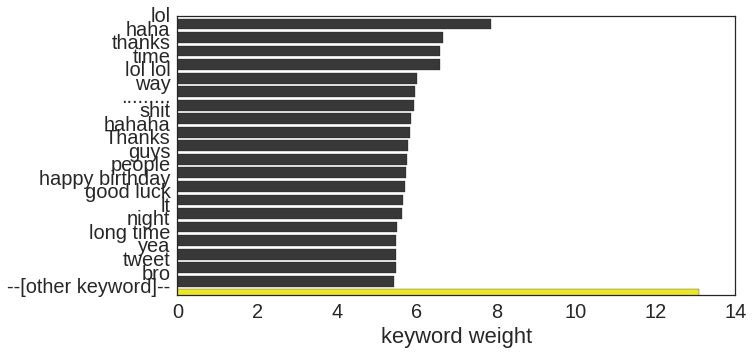

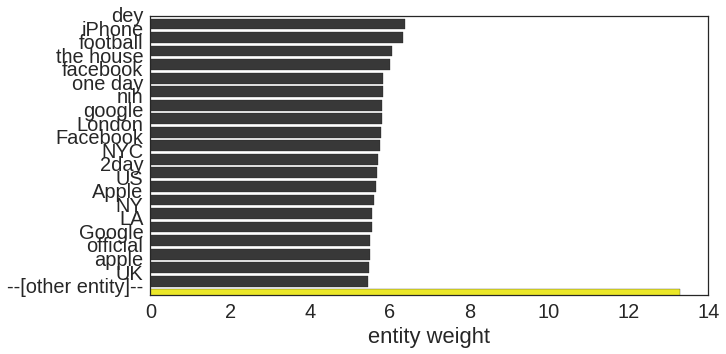

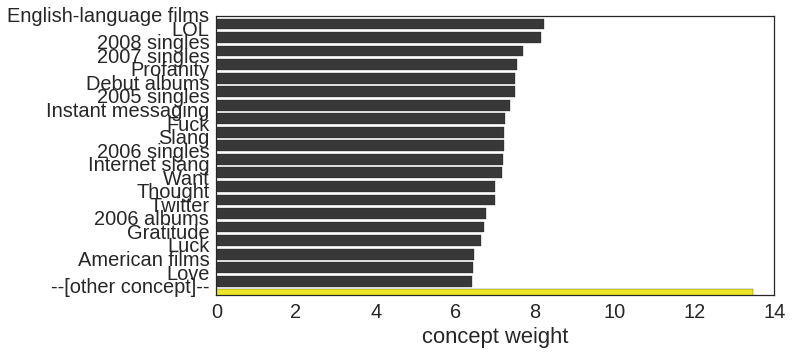

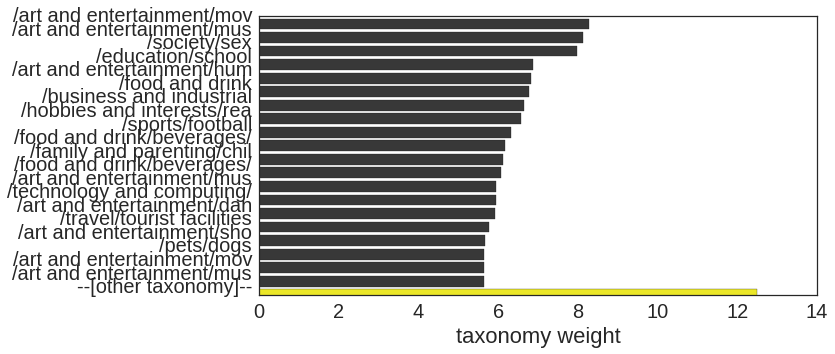

In [890]:
main('ALL')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


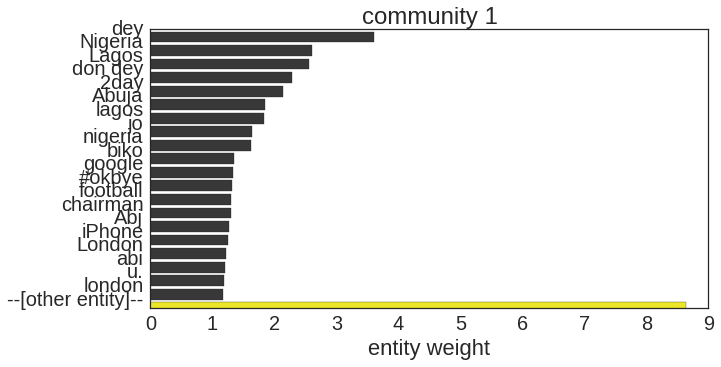

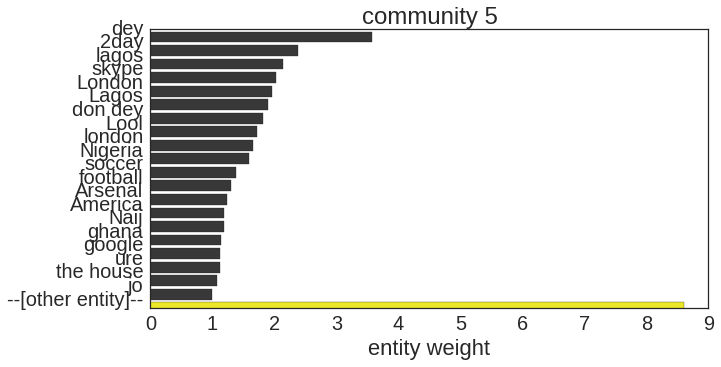

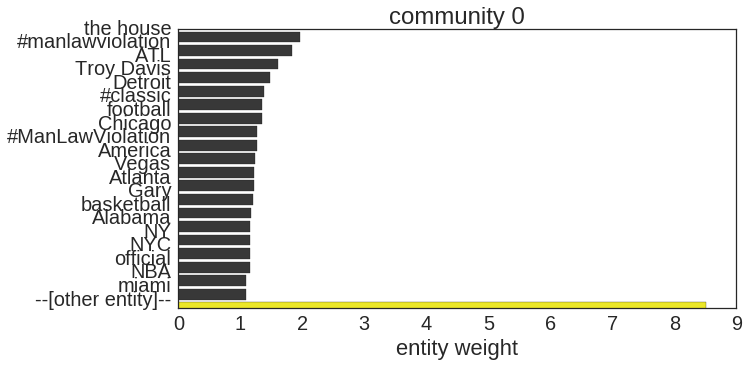

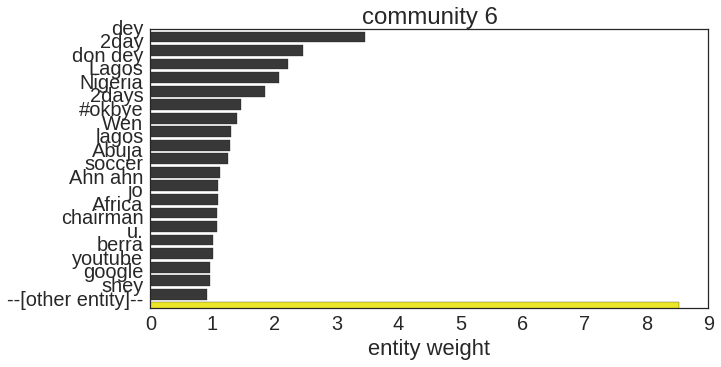

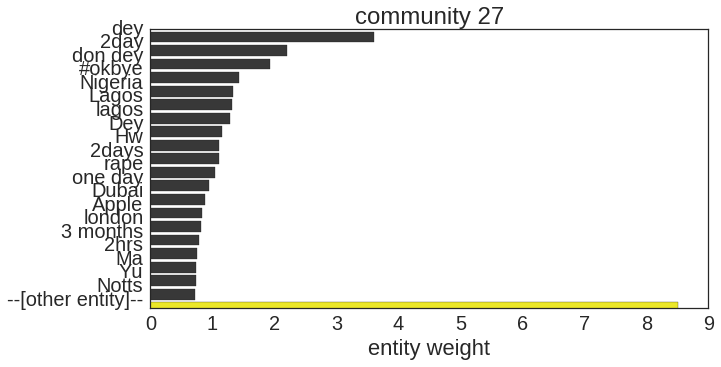

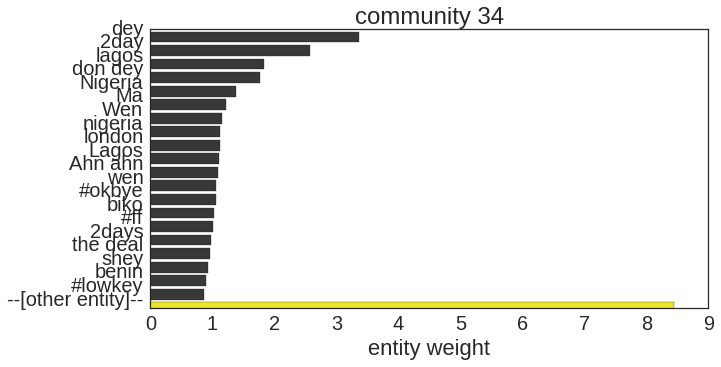

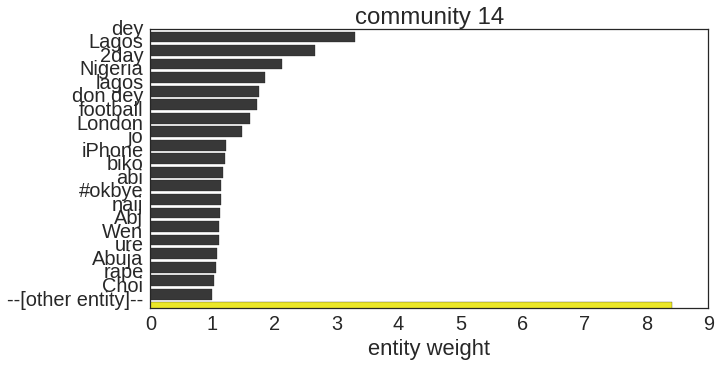

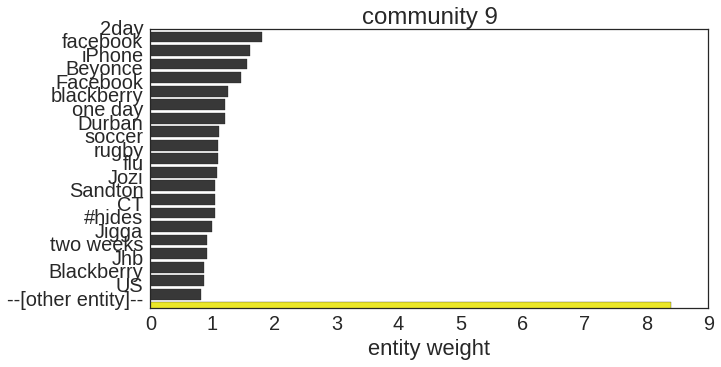

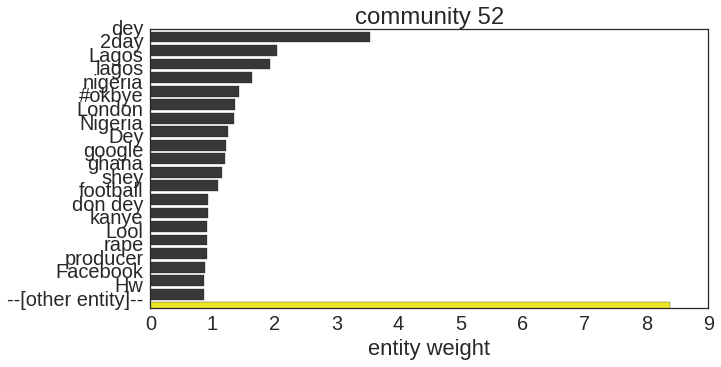

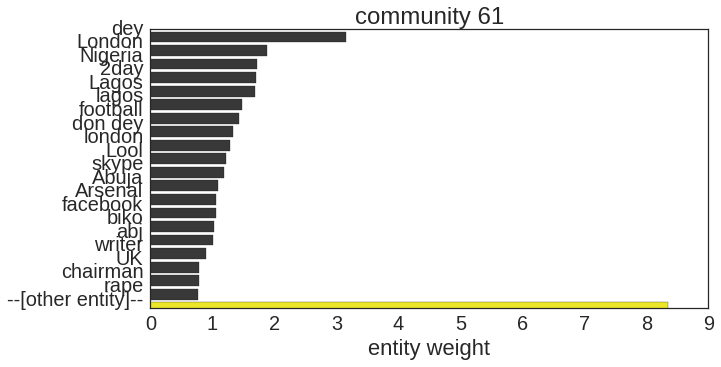

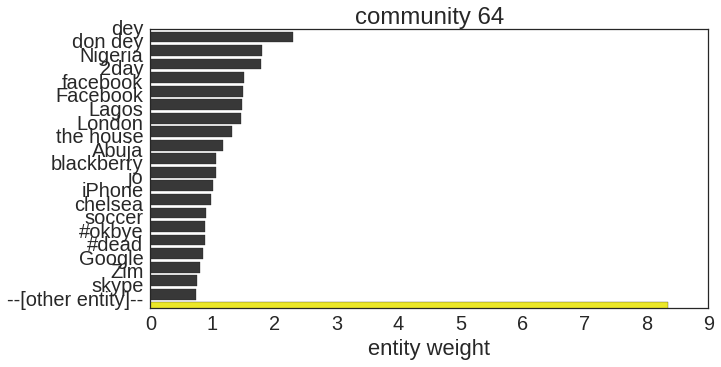

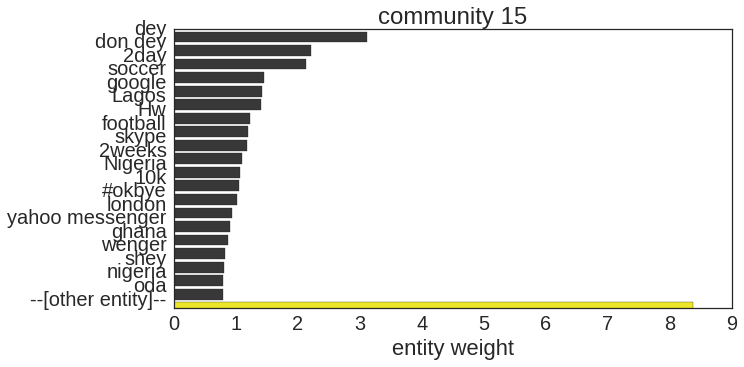

In [166]:
main(sizeN=181)